# Part 1 - Learning Prompts for Transfer Learning

In [5]:
## get home directory
import os
HOME = os.getcwd()
print('HOME: ',HOME)

HOME:  /content


# Install The Datasets

**Oxford Pets** = pets_train_loader, pets_test_loader

**Food101** = food_train_loader, food_test_loader

**CIFAR100** = cifar_train_loader, cifar_test_loader

**CIFAR10** = cifar10_train_loader, cifar10_test_loader

**MNIST** = mnist_train_loader, mnist_test_loader

In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import datasets

# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

PETS_BATCH_SIZE = 32
FOOD_BATCH_SIZE = 32
CIFAR_BATCH_SIZE = 32
MNIST_BATCH_SIZE = 32

## Oxford_pets Dataset

In [6]:
## Install oxford-pets dataset
!mkdir {HOME}/DATA
DATA_PATH = os.path.join(HOME, 'DATA')

if "oxford_pets" in os.listdir(DATA_PATH):
    print("Dataset already exists")
else:
    !mkdir {DATA_PATH}/oxford_pets
    %cd {DATA_PATH}/oxford_pets
    print("Downloading the data...")
    !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
    !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzf images.tar.gz
    !tar xzf annotations.tar.gz
    print("Extraction done!")

/content/DATA/oxford_pets
--2023-12-21 16:13:34--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-12-21 16:13:35--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-12-21 16:13:35--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (75

In [7]:
file_path = os.path.join(HOME, 'DATA', 'oxford_pets', 'annotations', 'test.txt')
with open(file_path, 'r') as f:
    lines = f.readlines()
    lines = [(line.split(' ')[0], line.split(' ')[1]) for line in lines]
    pets_class_mapper = {}
    for line in lines:
        if line[1] not in pets_class_mapper:
            cls = line[0].replace('_',' ')
            pets_class_mapper[int(line[1])] = ''.join([i for i in cls if not i.isdigit()])

print(pets_class_mapper)

{1: 'Abyssinian ', 2: 'american bulldog ', 3: 'american pit bull terrier ', 4: 'basset hound ', 5: 'beagle ', 6: 'Bengal ', 7: 'Birman ', 8: 'Bombay ', 9: 'boxer ', 10: 'British Shorthair ', 11: 'chihuahua ', 12: 'Egyptian Mau ', 13: 'english cocker spaniel ', 14: 'english setter ', 15: 'german shorthaired ', 16: 'great pyrenees ', 17: 'havanese ', 18: 'japanese chin ', 19: 'keeshond ', 20: 'leonberger ', 21: 'Maine Coon ', 22: 'miniature pinscher ', 23: 'newfoundland ', 24: 'Persian ', 25: 'pomeranian ', 26: 'pug ', 27: 'Ragdoll ', 28: 'Russian Blue ', 29: 'saint bernard ', 30: 'samoyed ', 31: 'scottish terrier ', 32: 'shiba inu ', 33: 'Siamese ', 34: 'Sphynx ', 35: 'staffordshire bull terrier ', 36: 'wheaten terrier ', 37: 'yorkshire terrier '}


In [8]:
class OxfordPetsDataset(Dataset):
    def __init__(self, directory, split='test', transform=None):

        file = os.path.join(directory, 'annotations', split+'.txt')
        self.data = []
        with open(file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                line = line.split(' ')
                self.data.append((line[0], int(line[1]) - 1))

        self.transform = transform
        self.directory = directory

    def __getitem__(self, index):
        img = self.load_image(index)
        class_idx = self.data[index][1]

        if self.transform:
            img = self.transform(img)
            if img.shape[0] == 4:
                img = img[1:]
        return img, class_idx

    def __len__(self):
        return len(self.data)

    def load_image(self, index):
        image_path = os.path.join(self.directory, 'images', self.data[index][0]+'.jpg')
        return Image.open(image_path)


In [9]:
ANN_DIR = os.path.join(HOME, 'DATA', 'oxford_pets')

#Build datasets
pets_train_data = OxfordPetsDataset(ANN_DIR, split='trainval', transform=train_transforms)
pets_test_data = OxfordPetsDataset(ANN_DIR, split='test', transform=test_transforms)

print(len(pets_train_data), len(pets_test_data))

3680 3669


In [10]:
#Build dataloaders
pets_train_loader = DataLoader(pets_train_data, PETS_BATCH_SIZE, shuffle=True, drop_last=True)
pets_test_loader = DataLoader(pets_test_data, PETS_BATCH_SIZE, shuffle=True, drop_last=True)

In [11]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(pets_train_loader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")
print(f"label value: {label_custom}")
print(f"class: ", [pets_class_mapper[int(label)+1] for label in label_custom])

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])
label value: tensor([ 3, 10, 21, 21,  0, 11, 14,  8, 23, 18, 31, 10,  9, 30, 22, 27, 13,  7,
        21, 18,  4, 24,  4,  2, 14, 24, 13, 17, 13,  9, 22, 33])
class:  ['basset hound ', 'chihuahua ', 'miniature pinscher ', 'miniature pinscher ', 'Abyssinian ', 'Egyptian Mau ', 'german shorthaired ', 'boxer ', 'Persian ', 'keeshond ', 'shiba inu ', 'chihuahua ', 'British Shorthair ', 'scottish terrier ', 'newfoundland ', 'Russian Blue ', 'english setter ', 'Bombay ', 'miniature pinscher ', 'keeshond ', 'beagle ', 'pomeranian ', 'beagle ', 'american pit bull terrier ', 'german shorthaired ', 'pomeranian ', 'english setter ', 'japanese chin ', 'english setter ', 'British Shorthair ', 'newfoundland ', 'Sphynx ']


## food-101 Dataset

In [ ]:
## Install the food101 dataset
from torchvision.datasets import Food101

%cd {HOME}/DATA

Food101_path = os.path.join(HOME, 'DATA')

food_train_data = Food101(Food101_path, split='train', download=True)
food_test_data = Food101(Food101_path, split='test', download=True)

/content/DATA


100%|██████████| 4996278331/4996278331 [03:26<00:00, 24186867.06it/s]


Extracting /content/DATA/food-101.tar.gz to /content/DATA


In [ ]:
food101_train_path = os.path.join(food_train_data.root, 'food-101', 'images')
food101_test_path = os.path.join(food_test_data.root, 'food-101', 'images')

food_train_data = datasets.ImageFolder(root=food101_train_path, # target folder of images
                                  transform=train_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

food_test_data = datasets.ImageFolder(root=food101_test_path,
                                 transform=test_transforms)

food_class_mapper = food_train_data.class_to_idx

In [ ]:
#Build dataloaders
food_train_loader = DataLoader(food_train_data, FOOD_BATCH_SIZE, shuffle=True, drop_last=True)
food_test_loader = DataLoader(food_test_data, FOOD_BATCH_SIZE, shuffle=False, drop_last=True)

In [ ]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(food_train_loader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")
print(f"label value: {label_custom}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])
label value: tensor([ 84,  33,  26,  63,  18,  38,  94,  85,  19,  84,  87,  37,  33,  21,
         77,  29,   3,  39,  15,   1,   3,  12,   4,  18,  92,  12,  52,  40,
         92,  56, 100,  92])


## CIFAR100 Dataset

In [ ]:
from torchvision.datasets import CIFAR100

%cd {HOME}/DATA

cifar_path = os.path.join(HOME, 'DATA')

cifar_train_data = CIFAR100(cifar_path, train=True, transform=train_transforms, download=True)
cifar_test_data = CIFAR100(cifar_path, train=False, transform=test_transforms, download=True)

/content/DATA


100%|██████████| 169001437/169001437 [00:02<00:00, 78419419.21it/s]


Extracting /content/DATA/cifar-100-python.tar.gz to /content/DATA
Files already downloaded and verified


In [ ]:
#Get the class mapper
cifar_class_mapper = cifar_train_data.class_to_idx

#Build dataloaders
cifar_train_loader = DataLoader(cifar_train_data, CIFAR_BATCH_SIZE, shuffle=True, drop_last=True)
cifar_test_loader = DataLoader(cifar_test_data, CIFAR_BATCH_SIZE, shuffle=False, drop_last=True)

In [ ]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(cifar_train_loader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")
print(f"label value: {label_custom}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])
label value: tensor([43, 48, 99, 49, 38, 26, 27, 67, 72, 40, 10, 77, 67, 34, 33, 16, 84, 61,
        57, 46, 41, 52, 18, 31, 62, 60, 18, 84, 82, 32, 91, 81])


## CIFAR10 Dataset

In [ ]:
from torchvision.datasets import CIFAR10

cifar10_path = os.path.join(HOME, 'DATA')

cifar10_train_data = CIFAR10(cifar10_path, train=True, transform=train_transforms, download=True)
cifar10_test_data = CIFAR10(cifar10_path, train=False, transform=test_transforms, download=True)

100%|██████████| 170498071/170498071 [00:06<00:00, 27978531.34it/s]


Extracting /content/DATA/cifar-10-python.tar.gz to /content/DATA
Files already downloaded and verified


In [ ]:
#Get the class mapper
cifar10_class_mapper = cifar10_train_data.class_to_idx

#Build dataloaders
cifar10_train_loader = DataLoader(cifar10_train_data, CIFAR_BATCH_SIZE, shuffle=True, drop_last=True)
cifar10_test_loader = DataLoader(cifar10_test_data, CIFAR_BATCH_SIZE, shuffle=False, drop_last=True)

In [ ]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(cifar10_train_loader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")
print(f"label value: {label_custom}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])
label value: tensor([9, 2, 9, 4, 4, 5, 4, 9, 4, 6, 0, 4, 9, 2, 2, 2, 5, 5, 8, 7, 4, 1, 7, 9,
        5, 4, 1, 1, 5, 6, 4, 3])


## MNIST Dataset

In [ ]:
from torchvision.datasets import MNIST

%cd {HOME}/DATA

mnist_path = os.path.join(HOME, 'DATA')

mnist_train_data = MNIST(mnist_path, train=True, transform=train_transforms, download=True)
mnist_test_data = MNIST(mnist_path, train=False, transform=test_transforms, download=True)

[Errno 2] No such file or directory: '/content/DATA'
/content


100%|██████████| 9912422/9912422 [00:00<00:00, 157098150.16it/s]

Extracting /content/DATA/MNIST/raw/train-images-idx3-ubyte.gz to /content/DATA/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 47485571.86it/s]


Extracting /content/DATA/MNIST/raw/train-labels-idx1-ubyte.gz to /content/DATA/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 56229959.40it/s]

Extracting /content/DATA/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/DATA/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6884903.78it/s]


Extracting /content/DATA/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/DATA/MNIST/raw



In [ ]:
#Get the class mapper
mnist_class_mapper = mnist_train_data.class_to_idx

#Build dataloaders
mnist_train_loader = DataLoader(mnist_train_data, MNIST_BATCH_SIZE, shuffle=True, drop_last=True)
mnist_test_loader = DataLoader(mnist_test_data, MNIST_BATCH_SIZE, shuffle=False, drop_last=True)

In [ ]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(mnist_train_loader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")
print(f"label value: {label_custom}")

Image shape: torch.Size([32, 1, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])
label value: tensor([2, 5, 2, 3, 9, 4, 5, 0, 0, 2, 6, 2, 9, 5, 0, 4, 7, 6, 8, 3, 3, 8, 0, 6,
        4, 4, 1, 6, 7, 0, 7, 0])


## Install CLIP

In [12]:
## Install CLIP
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 854.5 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-go_git_u
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-go_git_u
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=e5baa63b5b65a232fa8feadd8bc3b6bc13c275ca790654fb058408a107ad5a0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-8_8u1baf/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [13]:
## Import CLIP
import numpy as np
import torch
import torch.nn as nn
import clip
from tqdm.notebook import tqdm

from clip.simple_tokenizer import SimpleTokenizer
_tokenizer = SimpleTokenizer()

try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Define the CoOp model

In [14]:
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1,0,2)
        x = self.transformer(x)
        x = x.permute(1,0,2)
        x = self.ln_final(x).type(self.dtype)

        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x

In [15]:
class PromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, n_context=16, init_words='', class_token_pos = "end", csc=False):
        super().__init__()
        n_cls = len(classnames)
        n_ctx = n_context
        ctx_init = init_words
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]

        # use given words to initialize context vectors
        if ctx_init:
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(" "))
            prompt = clip.tokenize(ctx_init).to(device)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            # random initialization
            if csc: # Class-Specific-Context
                ctx_vectors = torch.empty(n_cls, n_ctx, ctx_dim, dtype=dtype)
            else: # Generic context
                ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        self.ctx = nn.Parameter(ctx_vectors)  # to be optimized

        #classnames = [name.replace('_',' ') for name in classnames]
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [prompt_prefix + ' ' + name + '.' for name in classnames]

        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)

        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # CLS, EOS

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts
        self.name_lens = name_lens
        self.class_token_pos = class_token_pos

    def forward(self):
        ctx = self.ctx
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        prefix = self.token_prefix
        suffix = self.token_suffix

        if self.class_token_pos == "end":
            # prefix (n_cls, 1, dim)
            # context (n_cls, n_ctx, dim)
            # suffix (n_cls, *, dim)
            prompts = torch.cat([prefix, ctx, suffix], dim=1)
        elif self.class_token_pos == "middle":
            half_n_ctx = self.n_ctx // 2
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i_half1 = ctx[i : i + 1, :half_n_ctx, :]
                ctx_i_half2 = ctx[i : i + 1, half_n_ctx:, :]

                prompt = torch.cat([prefix_i, ctx_i_half1, class_i, ctx_i_half2, suffix_i], dim=1)
                prompts.append(prompt)

            prompts = torch.cat(prompts, dim=0)
        elif self.class_token_position == "front":
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i = ctx[i : i + 1, :, :]
                prompt = torch.cat([prefix_i, class_i, ctx_i, suffix_i], dim=1)
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)
        else:
            raise ValueError

        return prompts

In [16]:
class CoOp(nn.Module):
    def __init__(self, classnames, clip_model, n_context=16, init_words='', class_token_pos='end', csc=False):
        super().__init__()
        self.prompt_learner = PromptLearner(clip_model, classnames, n_context=n_context, init_words=init_words, class_token_pos=class_token_pos, csc=csc)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image):
        image_features = self.image_encoder(image.type(self.dtype))

        prompts = self.prompt_learner()
        tokenized_prompts = self.tokenized_prompts
        text_features = self.text_encoder(prompts, tokenized_prompts)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return image_features, text_features, logits

## Define the training and test functions

In [17]:
def train_step(model, data_loader, optimizer, loss_fn, device=device):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (images, classes) in enumerate(data_loader):
        if images.shape[1] == 1:
            images = images.repeat(1,3,1,1)
        images, classes = images.to(device), classes.to(device)
        _ ,_, pred = model(images)
        loss = loss_fn(pred,classes)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(pred, dim=1), dim=1)
        train_acc += (y_pred_class == classes).sum().item() / len(pred)

    train_loss = train_loss / len(data_loader)
    train_acc = train_acc / len(data_loader)
    return train_loss, train_acc

def test_step(model, data_loader, loss_fn, device=device):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (images, classes) in enumerate(data_loader):
            if images.shape[1] == 1:
                images = images.repeat(1,3,1,1)
            images, classes = images.to(device), classes.to(device)
            _ ,_, pred = model(images)

            loss = loss_fn(pred, classes)
            test_loss += loss.item()

            pred_labels = pred.argmax(dim=1)
            test_acc += ((pred_labels == classes).sum().item() / len(pred_labels))

        test_loss = test_loss / len(data_loader)
        test_acc = test_acc / len(data_loader)
    return test_loss, test_acc

In [18]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model, train_loader, test_loader, optimizer, loss_fn, epochs=5, device=device):
    # 2. Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_loader, optimizer, loss_fn)
        test_loss, test_acc = test_step(model, test_loader, loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [28]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def custom_train(model, train_loader, test_loader, optimizer, loss_fn, classes, epochs=5, device=device, other_loss=None):
    # 2. Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = custom_train_step(model, train_loader, optimizer, loss_fn, classes, other_loss=other_loss)
        test_loss, test_acc = custom_test_step(model, test_loader, loss_fn, classes, other_loss=other_loss)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [19]:
## Plot the loss curve
import matplotlib.pyplot as plt

def plot_loss_curves(loss_dict):
    # Get the loss values of the results dictionary
    train_loss = loss_dict['train_loss']
    test_loss = loss_dict['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy = loss_dict['train_acc']
    test_accuracy = loss_dict['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(loss_dict['train_loss']))

    plt.figure(figsize=(12,5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [20]:
from pathlib import Path

def save_model(model: torch.nn.Module,target_dir: str,model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,target_dir="models",model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),f=model_save_path)

## Load clip model

In [21]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [22]:
## Load CLIP
clip_model, preprocess = clip.load("ViT-B/32")
#clip_model, preprocess = clip.load("RN50")
clip_model.to(device)
print(' ')

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 111MiB/s]


## Evaluate zero-shot CLIP

In [23]:
class CLIP_ZeroShot(nn.Module):
    def __init__(self, classes, clip_model, device=device):
        super().__init__()
        self.model = clip_model
        self.text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

    def forward(self, image):
        batch_size = image.shape[0]

        text_inputs = self.text_inputs
        with torch.no_grad():
            text_features = self.model.encode_text(text_inputs)

        value = torch.zeros(batch_size, dtype=torch.int64)
        index = torch.zeros(batch_size, dtype=torch.int64)

        for idx in range(batch_size):
            # Calculate features
            with torch.no_grad():
                image_features = self.model.encode_image(image[idx,:,:,:].unsqueeze(0))

            ## Normalize
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # Pick the most similar label
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            value[idx], index[idx] = similarity[0].topk(1)

        return value, index

In [24]:
def test_clip(model, data_loader, device=device):
    model.eval()

    test_acc = 0

    with torch.inference_mode():
        for images, classes in tqdm(data_loader):
            images = images.to(device)
            _, pred = model(images)

            test_acc += (pred == classes).sum() / classes.shape[0]

        test_acc = test_acc / len(data_loader)
    return test_acc

### zero-shot CLIP on cifar100 dataset

In [ ]:
cifar_classes = [cls.replace('_',' ') for cls in cifar_class_mapper.keys()]
print(cifar_classes)

['apple', 'aquarium fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak tree', 'orange', 'orchid', 'otter', 'palm tree', 'pear', 'pickup truck', 'pine tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow tree',

In [ ]:
# instantiate the model
model = CLIP_ZeroShot(cifar_classes, clip_model)

## Turning off gradients
for param in model.parameters():
    param.requires_grad_(False)

model = model.to(device)

# Evaluate the model
cifar_zero_shot = test_clip(model=model, data_loader=cifar_test_loader)
print(f"Test Accuracy: {float(cifar_zero_shot.cpu()):.3}")

  0%|          | 0/312 [00:00<?, ?it/s]

Test Accuracy: 0.374


### zero-shot CLIP on cifar10 dataset

In [ ]:
cifar10_classes = list(cifar10_class_mapper.keys())
print(cifar10_classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# instantiate the model
model = CLIP_ZeroShot(cifar10_classes, clip_model)

## Turning off gradients
for param in model.parameters():
    param.requires_grad_(False)

model = model.to(device)

# Evaluate the model
cifar10_zero_shot = test_clip(model=model, data_loader=cifar10_test_loader)
print(f"Test Accuracy: {float(cifar10_zero_shot.cpu()):.3}")

  0%|          | 0/312 [00:00<?, ?it/s]

Test Accuracy: 0.701


### zero-shot CLIP on food101 dataset

In [ ]:
food_classes = [cls.replace('_',' ') for cls in food_class_mapper.keys()]
print(food_classes)

['apple pie', 'baby back ribs', 'baklava', 'beef carpaccio', 'beef tartare', 'beet salad', 'beignets', 'bibimbap', 'bread pudding', 'breakfast burrito', 'bruschetta', 'caesar salad', 'cannoli', 'caprese salad', 'carrot cake', 'ceviche', 'cheese plate', 'cheesecake', 'chicken curry', 'chicken quesadilla', 'chicken wings', 'chocolate cake', 'chocolate mousse', 'churros', 'clam chowder', 'club sandwich', 'crab cakes', 'creme brulee', 'croque madame', 'cup cakes', 'deviled eggs', 'donuts', 'dumplings', 'edamame', 'eggs benedict', 'escargots', 'falafel', 'filet mignon', 'fish and chips', 'foie gras', 'french fries', 'french onion soup', 'french toast', 'fried calamari', 'fried rice', 'frozen yogurt', 'garlic bread', 'gnocchi', 'greek salad', 'grilled cheese sandwich', 'grilled salmon', 'guacamole', 'gyoza', 'hamburger', 'hot and sour soup', 'hot dog', 'huevos rancheros', 'hummus', 'ice cream', 'lasagna', 'lobster bisque', 'lobster roll sandwich', 'macaroni and cheese', 'macarons', 'miso sou

In [ ]:
# instantiate the model
model = CLIP_ZeroShot(food_classes, clip_model)

## Turning off gradients
for param in model.parameters():
    param.requires_grad_(False)

model = model.to(device)

# Evaluate the model
food_zero_shot = test_clip(model=model, data_loader=food_test_loader)
print(f"Test Accuracy: {float(food_zero_shot.cpu()):.3}")

  0%|          | 0/3156 [00:00<?, ?it/s]

Test Accuracy: 0.677


### zero-shot CLIP on Oxford_pets dataset

In [25]:
pets_classes = pets_class_mapper.values()
print(pets_classes)

dict_values(['Abyssinian ', 'american bulldog ', 'american pit bull terrier ', 'basset hound ', 'beagle ', 'Bengal ', 'Birman ', 'Bombay ', 'boxer ', 'British Shorthair ', 'chihuahua ', 'Egyptian Mau ', 'english cocker spaniel ', 'english setter ', 'german shorthaired ', 'great pyrenees ', 'havanese ', 'japanese chin ', 'keeshond ', 'leonberger ', 'Maine Coon ', 'miniature pinscher ', 'newfoundland ', 'Persian ', 'pomeranian ', 'pug ', 'Ragdoll ', 'Russian Blue ', 'saint bernard ', 'samoyed ', 'scottish terrier ', 'shiba inu ', 'Siamese ', 'Sphynx ', 'staffordshire bull terrier ', 'wheaten terrier ', 'yorkshire terrier '])


In [ ]:
# instantiate the model
model = CLIP_ZeroShot(pets_classes, clip_model)

## Turning off gradients
for param in model.parameters():
    param.requires_grad_(False)

model = model.to(device)

# Evaluate the model
pets_zero_shot = test_clip(model=model, data_loader=pets_test_loader)
print(f"Test Accuracy: {float(pets_zero_shot.cpu()):.3}")

  0%|          | 0/114 [00:00<?, ?it/s]

Test Accuracy: 0.764


In [ ]:
mnist_classes = mnist_train_data.classes

## Train the CoOp model

In [ ]:
%cd {HOME}

# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

datasets = ['oxford_pets', 'cifar100', 'cifar10', 'food101', 'MNIST']

## Iterate through all datasets
for dataset in datasets:
    print(f'training CoOp on {dataset}...')

    # instantiate the model
    if dataset == 'oxford_pets':
        model = CoOp(pets_classes, clip_model)
    elif dataset == 'food101':
        model = CoOp(food_classes, clip_model)
    elif dataset == 'cifar100':
        model = CoOp(cifar_classes, clip_model)
    elif dataset == 'cifar10':
        model = CoOp(cifar10_classes, clip_model)
    elif dataset == 'MNIST':
        model = CoOp(mnist_classes, clip_model)

    ## Turning off gradients in both the image and the text encoder
    for name, param in model.named_parameters():
                if "prompt_learner" not in name:
                    param.requires_grad_(False)

    model = model.to(device)

    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()

    # NOTE: only give prompt_learner to the optimizer
    optimizer = torch.optim.SGD(params=model.prompt_learner.parameters(), lr=0.002)

    # Train model
    if dataset == 'oxford_pets':
        pets_model_results = train(model=model, train_loader=pets_train_loader, test_loader=pets_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
    elif dataset == 'food101':
        food_model_results = train(model=model, train_loader=food_train_loader, test_loader=food_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
    elif dataset == 'cifar100':
        cifar_model_results = train(model=model, train_loader=cifar_train_loader, test_loader=cifar_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
    elif dataset == 'cifar10':
        cifar10_model_results = train(model=model, train_loader=cifar10_train_loader, test_loader=cifar10_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
    elif dataset == 'MNIST':
        mnist_model_results = train(model=model, train_loader=mnist_train_loader, test_loader=mnist_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)

    ## Save the model
    model_name = f'CoOp_{dataset}.pt'
    save_model(model=model, target_dir='models', model_name=model_name)

    ## Plot curves
    #plot_loss_curves(model_results)

/content
training CoOp on MNIST...
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5619 | train_acc: 0.8353 | test_loss: 0.3379 | test_acc: 0.9118
Epoch: 2 | train_loss: 0.3282 | train_acc: 0.9116 | test_loss: 0.2815 | test_acc: 0.9295
Epoch: 3 | train_loss: 0.2860 | train_acc: 0.9245 | test_loss: 0.2615 | test_acc: 0.9319
Epoch: 4 | train_loss: 0.2629 | train_acc: 0.9309 | test_loss: 0.2468 | test_acc: 0.9356
Epoch: 5 | train_loss: 0.2485 | train_acc: 0.9357 | test_loss: 0.2190 | test_acc: 0.9470
[INFO] Saving model to: models/CoOp_MNIST.pt


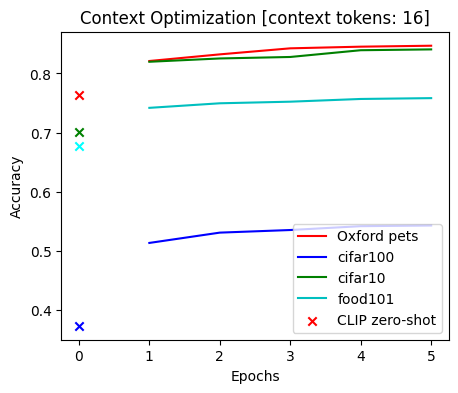

In [ ]:
import matplotlib.pyplot as plt

n_epochs = range(1, NUM_EPOCHS+1)

plt.figure(figsize=(5,4))
plt.plot(n_epochs, pets_model_results['test_acc'], 'r', label='Oxford pets')
plt.plot(n_epochs, cifar_model_results['test_acc'], 'b', label='cifar100')
plt.plot(n_epochs, cifar10_model_results['test_acc'], 'g', label='cifar10')
plt.plot(n_epochs, food_model_results['test_acc'], 'c', label='food101')
plt.scatter(x=0, y=pets_zero_shot, marker='x', c='red', label='CLIP zero-shot')
plt.scatter(x=0, y=cifar_zero_shot, marker='x', c='blue')
plt.scatter(x=0, y=cifar10_zero_shot, marker='x', c='green')
plt.scatter(x=0, y=food_zero_shot, marker='x', c='cyan')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Context Optimization [context tokens: 16]')
plt.legend(loc='lower right')
plt.show()

## Train CoOp with various hyperparameters

training on oxford_pets... (class position = [end] / class-specific = [True])
Initial context: "X X X X X X X X"
Number of context words (tokens): 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7442 | train_acc: 0.7606 | test_loss: 0.5578 | test_acc: 0.8152
Epoch: 2 | train_loss: 0.5120 | train_acc: 0.8397 | test_loss: 0.5039 | test_acc: 0.8262
Epoch: 3 | train_loss: 0.4353 | train_acc: 0.8701 | test_loss: 0.4925 | test_acc: 0.8333
Epoch: 4 | train_loss: 0.3941 | train_acc: 0.8889 | test_loss: 0.4864 | test_acc: 0.8363
Epoch: 5 | train_loss: 0.3665 | train_acc: 0.8959 | test_loss: 0.4730 | test_acc: 0.8374
training on oxford_pets... (class position = [end] / class-specific = [False])
Initial context: "X X X X X X X X"
Number of context words (tokens): 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6337 | train_acc: 0.7908 | test_loss: 0.4921 | test_acc: 0.8331
Epoch: 2 | train_loss: 0.5462 | train_acc: 0.8149 | test_loss: 0.4757 | test_acc: 0.8374
Epoch: 3 | train_loss: 0.5180 | train_acc: 0.8264 | test_loss: 0.4737 | test_acc: 0.8372
Epoch: 4 | train_loss: 0.4959 | train_acc: 0.8361 | test_loss: 0.4671 | test_acc: 0.8342
Epoch: 5 | train_loss: 0.4818 | train_acc: 0.8427 | test_loss: 0.4500 | test_acc: 0.8468
training on oxford_pets... (class position = [middle] / class-specific = [True])
Initial context: "X X X X X X X X"
Number of context words (tokens): 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7437 | train_acc: 0.7647 | test_loss: 0.5415 | test_acc: 0.8199
Epoch: 2 | train_loss: 0.5055 | train_acc: 0.8505 | test_loss: 0.5105 | test_acc: 0.8317
Epoch: 3 | train_loss: 0.4363 | train_acc: 0.8658 | test_loss: 0.5040 | test_acc: 0.8331
Epoch: 4 | train_loss: 0.4021 | train_acc: 0.8736 | test_loss: 0.4792 | test_acc: 0.8374
Epoch: 5 | train_loss: 0.3701 | train_acc: 0.8908 | test_loss: 0.4757 | test_acc: 0.8424
training on oxford_pets... (class position = [middle] / class-specific = [False])
Initial context: "X X X X X X X X"
Number of context words (tokens): 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6021 | train_acc: 0.8041 | test_loss: 0.5007 | test_acc: 0.8279
Epoch: 2 | train_loss: 0.5146 | train_acc: 0.8304 | test_loss: 0.4747 | test_acc: 0.8407
Epoch: 3 | train_loss: 0.4880 | train_acc: 0.8394 | test_loss: 0.4676 | test_acc: 0.8399
Epoch: 4 | train_loss: 0.4711 | train_acc: 0.8457 | test_loss: 0.4695 | test_acc: 0.8405
Epoch: 5 | train_loss: 0.4540 | train_acc: 0.8500 | test_loss: 0.4686 | test_acc: 0.8402


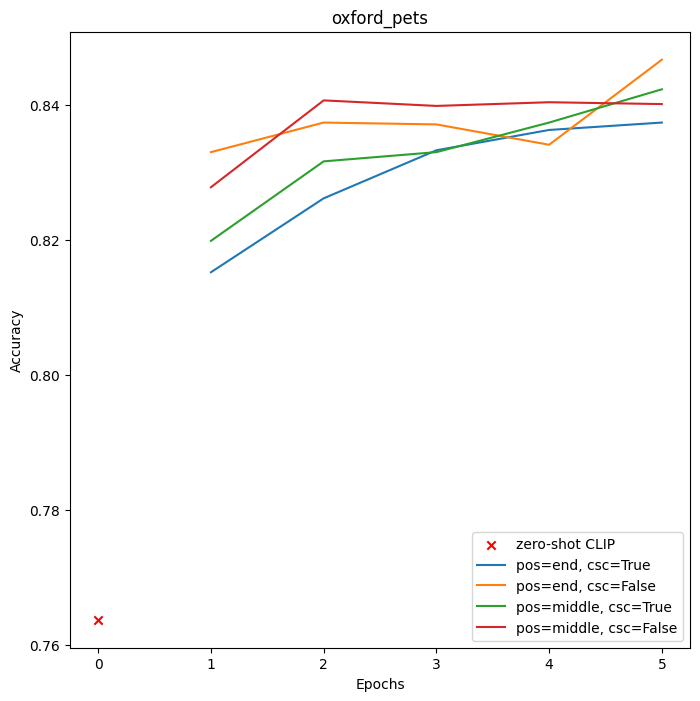

training on cifar10... (class position = [end] / class-specific = [True])
Initial context: "X X X X X X X X"
Number of context words (tokens): 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5242 | train_acc: 0.8219 | test_loss: 0.4779 | test_acc: 0.8387
Epoch: 2 | train_loss: 0.4532 | train_acc: 0.8463 | test_loss: 0.4538 | test_acc: 0.8409
Epoch: 3 | train_loss: 0.4333 | train_acc: 0.8524 | test_loss: 0.4430 | test_acc: 0.8459
Epoch: 4 | train_loss: 0.4219 | train_acc: 0.8573 | test_loss: 0.4421 | test_acc: 0.8474
Epoch: 5 | train_loss: 0.4157 | train_acc: 0.8584 | test_loss: 0.4339 | test_acc: 0.8488
training on cifar10... (class position = [end] / class-specific = [False])
Initial context: "X X X X X X X X"
Number of context words (tokens): 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5557 | train_acc: 0.8100 | test_loss: 0.5221 | test_acc: 0.8197
Epoch: 2 | train_loss: 0.4945 | train_acc: 0.8320 | test_loss: 0.5100 | test_acc: 0.8253
Epoch: 3 | train_loss: 0.4767 | train_acc: 0.8378 | test_loss: 0.5031 | test_acc: 0.8278
Epoch: 4 | train_loss: 0.4651 | train_acc: 0.8431 | test_loss: 0.4749 | test_acc: 0.8392
Epoch: 5 | train_loss: 0.4585 | train_acc: 0.8445 | test_loss: 0.4707 | test_acc: 0.8406
training on cifar10... (class position = [middle] / class-specific = [True])
Initial context: "X X X X X X X X"
Number of context words (tokens): 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5271 | train_acc: 0.8195 | test_loss: 0.4813 | test_acc: 0.8367
Epoch: 2 | train_loss: 0.4543 | train_acc: 0.8454 | test_loss: 0.4619 | test_acc: 0.8431
Epoch: 3 | train_loss: 0.4347 | train_acc: 0.8523 | test_loss: 0.4472 | test_acc: 0.8482
Epoch: 4 | train_loss: 0.4231 | train_acc: 0.8564 | test_loss: 0.4350 | test_acc: 0.8484
Epoch: 5 | train_loss: 0.4162 | train_acc: 0.8587 | test_loss: 0.4424 | test_acc: 0.8471
training on cifar10... (class position = [middle] / class-specific = [False])
Initial context: "X X X X X X X X"
Number of context words (tokens): 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5668 | train_acc: 0.8066 | test_loss: 0.5238 | test_acc: 0.8182
Epoch: 2 | train_loss: 0.4997 | train_acc: 0.8298 | test_loss: 0.4986 | test_acc: 0.8315
Epoch: 3 | train_loss: 0.4796 | train_acc: 0.8357 | test_loss: 0.4883 | test_acc: 0.8300
Epoch: 4 | train_loss: 0.4679 | train_acc: 0.8402 | test_loss: 0.4789 | test_acc: 0.8372
Epoch: 5 | train_loss: 0.4595 | train_acc: 0.8419 | test_loss: 0.4723 | test_acc: 0.8380


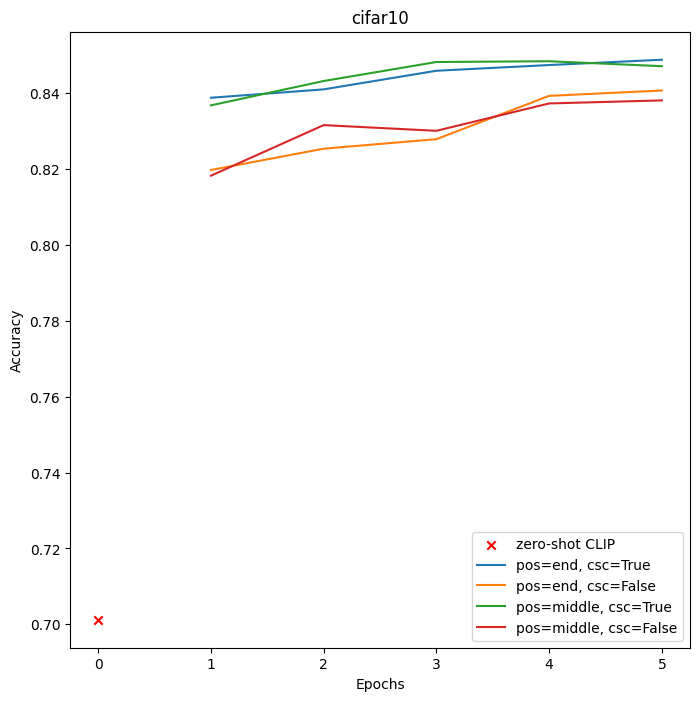

training on cifar100... (class position = [end] / class-specific = [True])
Initial context: "X X X X X X X X"
Number of context words (tokens): 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9041 | train_acc: 0.5106 | test_loss: 1.6462 | test_acc: 0.5547
Epoch: 2 | train_loss: 1.5442 | train_acc: 0.5838 | test_loss: 1.5215 | test_acc: 0.5843
Epoch: 3 | train_loss: 1.4497 | train_acc: 0.6046 | test_loss: 1.4700 | test_acc: 0.5939
Epoch: 4 | train_loss: 1.3952 | train_acc: 0.6195 | test_loss: 1.4447 | test_acc: 0.6014
Epoch: 5 | train_loss: 1.3569 | train_acc: 0.6306 | test_loss: 1.4101 | test_acc: 0.6084
training on cifar100... (class position = [end] / class-specific = [False])
Initial context: "X X X X X X X X"
Number of context words (tokens): 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9916 | train_acc: 0.4771 | test_loss: 1.8736 | test_acc: 0.4930
Epoch: 2 | train_loss: 1.7977 | train_acc: 0.5194 | test_loss: 1.7756 | test_acc: 0.5190
Epoch: 3 | train_loss: 1.7335 | train_acc: 0.5342 | test_loss: 1.7341 | test_acc: 0.5257
Epoch: 4 | train_loss: 1.6991 | train_acc: 0.5408 | test_loss: 1.7081 | test_acc: 0.5341
Epoch: 5 | train_loss: 1.6712 | train_acc: 0.5479 | test_loss: 1.7006 | test_acc: 0.5351
training on cifar100... (class position = [middle] / class-specific = [True])
Initial context: "X X X X X X X X"
Number of context words (tokens): 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9189 | train_acc: 0.5045 | test_loss: 1.6550 | test_acc: 0.5522
Epoch: 2 | train_loss: 1.5566 | train_acc: 0.5809 | test_loss: 1.5521 | test_acc: 0.5760
Epoch: 3 | train_loss: 1.4593 | train_acc: 0.6041 | test_loss: 1.4814 | test_acc: 0.5922
Epoch: 4 | train_loss: 1.4025 | train_acc: 0.6158 | test_loss: 1.4450 | test_acc: 0.5960
Epoch: 5 | train_loss: 1.3652 | train_acc: 0.6267 | test_loss: 1.4121 | test_acc: 0.6091
training on cifar100... (class position = [middle] / class-specific = [False])
Initial context: "X X X X X X X X"
Number of context words (tokens): 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9825 | train_acc: 0.4781 | test_loss: 1.8478 | test_acc: 0.5007
Epoch: 2 | train_loss: 1.7908 | train_acc: 0.5219 | test_loss: 1.7632 | test_acc: 0.5253
Epoch: 3 | train_loss: 1.7179 | train_acc: 0.5370 | test_loss: 1.7103 | test_acc: 0.5301
Epoch: 4 | train_loss: 1.6769 | train_acc: 0.5483 | test_loss: 1.6854 | test_acc: 0.5421
Epoch: 5 | train_loss: 1.6763 | train_acc: 0.5481 | test_loss: 1.6728 | test_acc: 0.5432


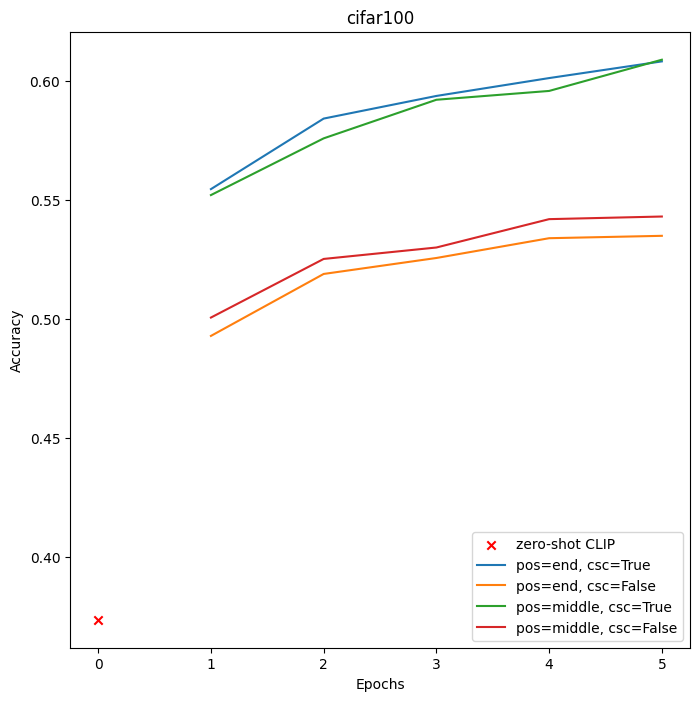

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

class_token_positions = ['end', 'middle']
class_specific_context = [True, False]
context_tokens = [4, 8, 16]
init_words = 'a photo of a'
datasets = ['oxford_pets', 'cifar10', 'cifar100']

for dataset in datasets:

    plt.figure(figsize=(8,8))
    if dataset == 'oxford_pets':
        plt.scatter(x=0, y=pets_zero_shot, marker='x', c='red', label='zero-shot CLIP')
    elif dataset == 'food101':
        plt.scatter(x=0, y=food_zero_shot, marker='x', c='red', label='zero-shot CLIP')
    elif dataset == 'cifar10':
        plt.scatter(x=0, y=cifar10_zero_shot, marker='x', c='red', label='zero-shot CLIP')
    elif dataset == 'cifar100':
        plt.scatter(x=0, y=cifar_zero_shot, marker='x', c='red', label='zero-shot CLIP')

    for class_t in class_token_positions:
        for class_s in class_specific_context:
            print(f'training on {dataset}... (class position = [{class_t}] / class-specific = [{class_s}])')

            # instantiate the model
            if dataset == 'oxford_pets':
                model = CoOp(pets_classes, clip_model, n_context=8, init_words='', class_token_pos=class_t, csc=class_s)
            elif dataset == 'food101':
                model = CoOp(food_classes, clip_model, n_context=8, init_words='', class_token_pos=class_t, csc=class_s)
            elif dataset == 'cifar10':
                model = CoOp(cifar10_classes, clip_model, n_context=8, init_words='', class_token_pos=class_t, csc=class_s)
            elif dataset == 'cifar100':
                model = CoOp(cifar_classes, clip_model, n_context=8, init_words='', class_token_pos=class_t, csc=class_s)

            ## Turning off gradients in both the image and the text encoder
            for name, param in model.named_parameters():
                        if "prompt_learner" not in name:
                            param.requires_grad_(False)

            model = model.to(device)

            # Setup loss function and optimizer
            loss_fn = nn.CrossEntropyLoss()

            # NOTE: only give prompt_learner to the optimizer
            optimizer = torch.optim.SGD(params=model.prompt_learner.parameters(), lr=0.002)

            # Train model
            if dataset == 'oxford_pets':
                model_results = train(model=model, train_loader=pets_train_loader, test_loader=pets_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
            elif dataset == 'food101':
                model_results = train(model=model, train_loader=food_train_loader, test_loader=food_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
            elif dataset == 'cifar10':
                model_results = train(model=model, train_loader=cifar10_train_loader, test_loader=cifar10_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
            elif dataset == 'cifar100':
                model_results = train(model=model, train_loader=cifar_train_loader, test_loader=cifar_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)

            plt.plot(range(1, NUM_EPOCHS+1), model_results['test_acc'], label=f'pos={class_t}, csc={class_s}')

    ## Plot the comparison between hyperparameters
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(dataset)
    plt.legend()
    plt.show()

## Train the CoOp model with different context vector sizes

Initial context: "X X X X"
Number of context words (tokens): 4
Testing with...
number of tokens: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5315 | train_acc: 0.5761 | test_loss: 0.7570 | test_acc: 0.7527
Epoch: 2 | train_loss: 0.5802 | train_acc: 0.8155 | test_loss: 0.5859 | test_acc: 0.8059
Epoch: 3 | train_loss: 0.4614 | train_acc: 0.8538 | test_loss: 0.5639 | test_acc: 0.8160
Epoch: 4 | train_loss: 0.3980 | train_acc: 0.8791 | test_loss: 0.5693 | test_acc: 0.8092
Epoch: 5 | train_loss: 0.3551 | train_acc: 0.8918 | test_loss: 0.5282 | test_acc: 0.8286
Initial context: "X X X X X X X X"
Number of context words (tokens): 8
Testing with...
number of tokens: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4776 | train_acc: 0.5981 | test_loss: 0.7766 | test_acc: 0.7500
Epoch: 2 | train_loss: 0.5767 | train_acc: 0.8160 | test_loss: 0.5983 | test_acc: 0.8002
Epoch: 3 | train_loss: 0.4340 | train_acc: 0.8685 | test_loss: 0.5864 | test_acc: 0.8106
Epoch: 4 | train_loss: 0.3741 | train_acc: 0.8894 | test_loss: 0.5520 | test_acc: 0.8150
Epoch: 5 | train_loss: 0.3262 | train_acc: 0.9092 | test_loss: 0.5246 | test_acc: 0.8270
Initial context: "X X X X X X X X X X X X"
Number of context words (tokens): 12
Testing with...
number of tokens: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5060 | train_acc: 0.5783 | test_loss: 0.7400 | test_acc: 0.7576
Epoch: 2 | train_loss: 0.5675 | train_acc: 0.8196 | test_loss: 0.6653 | test_acc: 0.7754
Epoch: 3 | train_loss: 0.4454 | train_acc: 0.8603 | test_loss: 0.5814 | test_acc: 0.8046
Epoch: 4 | train_loss: 0.3776 | train_acc: 0.8872 | test_loss: 0.5643 | test_acc: 0.8021
Epoch: 5 | train_loss: 0.3241 | train_acc: 0.9003 | test_loss: 0.5710 | test_acc: 0.8090


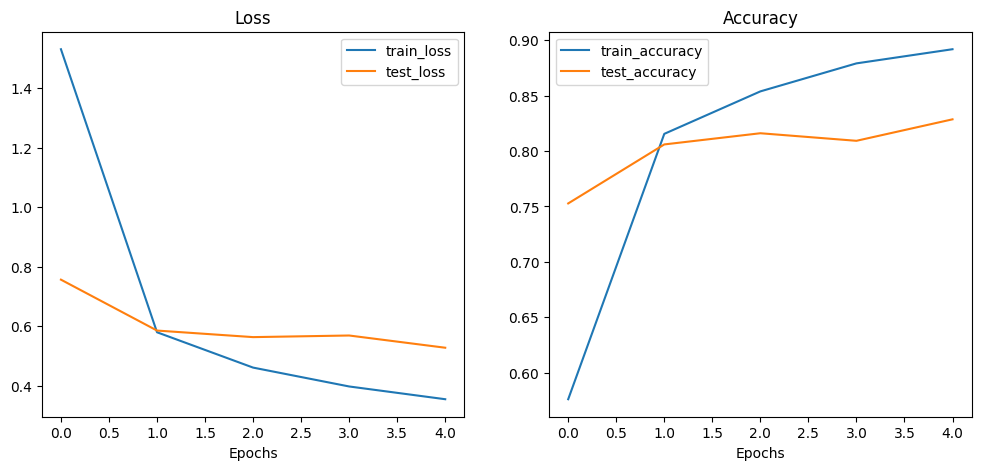

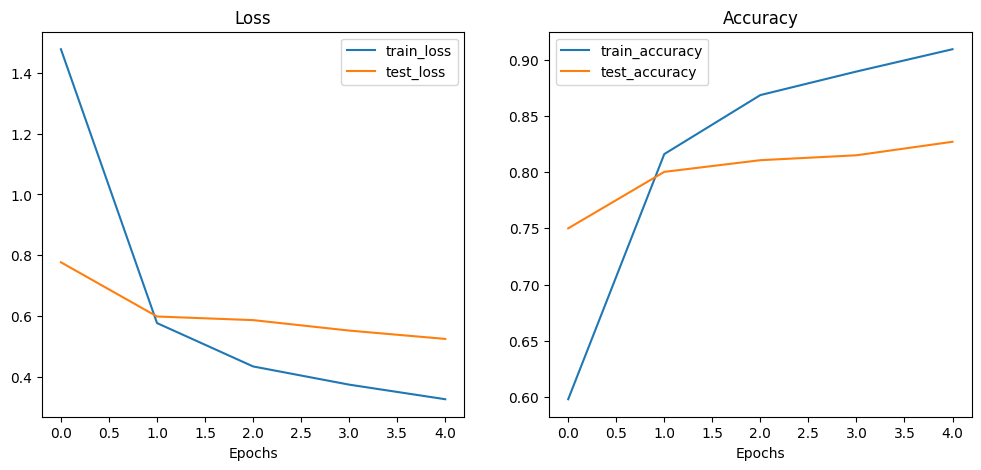

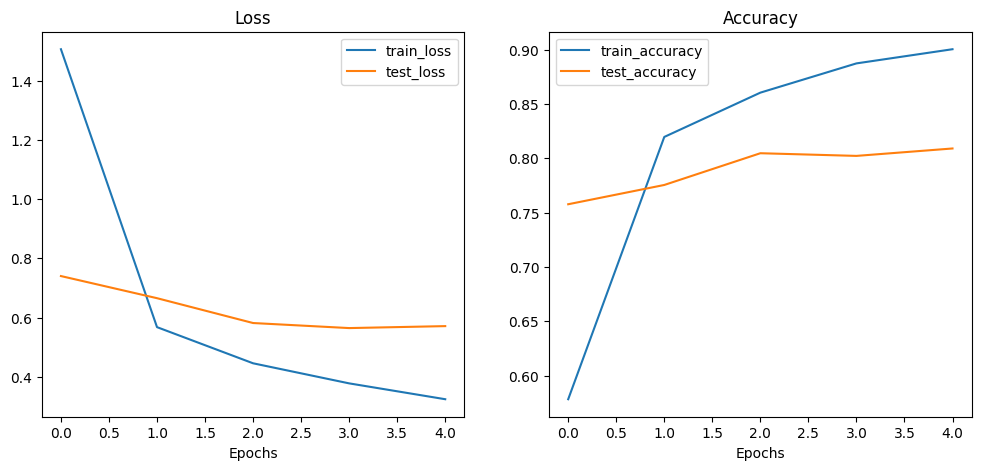

In [ ]:
context_tokens = [4, 8, 12]

for n_tokens in context_tokens:
    # instantiate the model
    model = CoOp(pets_classes, clip_model, n_context=n_tokens, init_words='', class_token_pos='end', csc=False)

    ## Turning off gradients in both the image and the text encoder
    for name, param in model.named_parameters():
                if "prompt_learner" not in name:
                    param.requires_grad_(False)

    model = model.to(device)

    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()

    # NOTE: only give prompt_learner to the optimizer
    optimizer = torch.optim.SGD(params=model.prompt_learner.parameters(), lr=0.002)

    # Train model
    print('Testing with...')
    print(f'number of tokens: {n_tokens}')
    model_results = train(model=model, train_loader=pets_train_loader, test_loader=pets_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)

    # Plot the results
    plot_loss_curves(model_results)

## Visualize CLIP embedding space using UMAP

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=21207eb4278befc8569fa594b173d2df27be531f9dbdd5e28f5e906201ef5d4d
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import umap
%matplotlib inline

In [ ]:
from matplotlib.colors import Normalize

def normalize_array(vec: np.ndarray):
    return vec / np.linalg.norm(vec, axis=1, keepdims=True)

def draw_umap(data, target, classnames, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=n_components,metric=metric)
    u = fit.fit_transform(data)

    fig = plt.figure(figsize=(8,8))
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=target, cmap='Spectral')
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=target, cmap='Spectral')
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=target, cmap='Spectral', s=20)

    # Create a ScalarMappable object to associate with the colorbar
    norm = Normalize(vmin=target.min(), vmax=target.max())
    sm = plt.cm.ScalarMappable(cmap='Spectral',norm=norm)
    sm.set_array([])

    # Add colorbar
    cbar = plt.colorbar(sm, boundaries=np.arange(len(classnames)+1)-0.5, label='Class Labels')
    cbar.set_ticks(np.arange(len(classnames)))
    cbar.set_ticklabels(classnames)
    plt.title(title, fontsize=18)

    # Show the plot
    plt.show()

## UMAP of the datasets

In [ ]:
CIFAR_BATCH_SIZE = 32

#Build dataloaders
cifar10_train_loader = DataLoader(cifar10_train_data, CIFAR_BATCH_SIZE, shuffle=True, drop_last=True)
cifar10_test_loader = DataLoader(cifar10_test_data, CIFAR_BATCH_SIZE, shuffle=False, drop_last=True)

# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(cifar10_train_loader))

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar10_classes]).to(device)
with torch.no_grad():
    image_features = clip_model.encode_image(img_custom)
    text_features = clip_model.encode_text(text_inputs)

cifar10_data = image_features.numpy()
cifar10_prompts = text_features.numpy()
cifar10_target = label_custom.numpy()

print(cifar10_data.shape)
print(cifar10_prompts.shape)
print(cifar10_target.shape)

In [ ]:
MNIST_BATCH_SIZE = 128

#Build dataloaders
mnist_train_loader = DataLoader(mnist_train_data, MNIST_BATCH_SIZE, shuffle=True, drop_last=True)
mnist_test_loader = DataLoader(mnist_test_data, MNIST_BATCH_SIZE, shuffle=False, drop_last=True)

# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(mnist_train_loader))

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in mnist_classes]).to(device)
with torch.no_grad():
    image_features = clip_model.encode_image(img_custom.repeat(1,3,1,1))
    text_features = clip_model.encode_text(text_inputs)

mnist_data = image_features.numpy()
mnist_prompts = text_features.numpy()
mnist_target = label_custom.numpy()

print(mnist_data.shape)
print(mnist_prompts.shape)
print(mnist_target.shape)

(128, 512)
(10, 512)
(128,)


In [ ]:
PETS_BATCH_SIZE = 128

#Build dataloaders
pets_train_loader = DataLoader(pets_train_data, PETS_BATCH_SIZE, shuffle=True, drop_last=True)
pets_test_loader = DataLoader(pets_test_data, PETS_BATCH_SIZE, shuffle=False, drop_last=True)

# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(pets_train_loader))

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in pets_classes]).to(device)
with torch.no_grad():
    image_features = clip_model.encode_image(img_custom)
    text_features = clip_model.encode_text(text_inputs)

pets_data = image_features.numpy()
pets_prompts = text_features.numpy()
pets_target = label_custom.numpy()

print(pets_data.shape)
print(pets_prompts.shape)
print(pets_target.shape)

(128, 512)
(37, 512)
(128,)


<ipython-input-39-5680c476e548>:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, boundaries=np.arange(len(classnames)+1)-0.5, label='Class Labels')


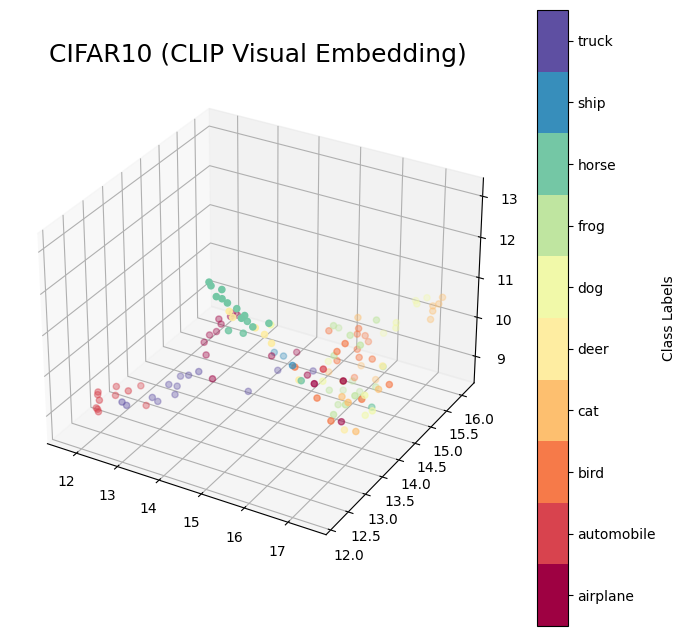

In [ ]:
draw_umap(cifar10_data, cifar10_target, cifar10_classes, n_components=3, title='CIFAR10 (CLIP Visual Embedding)')

<ipython-input-39-5680c476e548>:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, boundaries=np.arange(len(classnames)+1)-0.5, label='Class Labels')


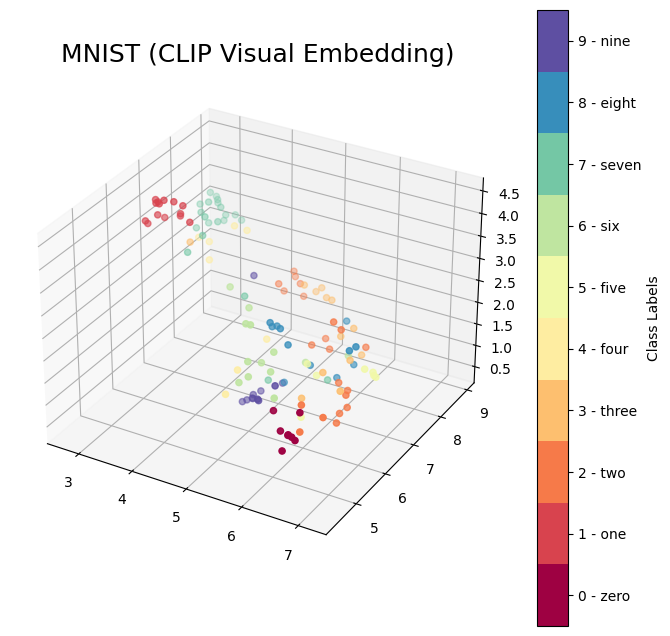

In [ ]:
draw_umap(mnist_data, mnist_target, mnist_classes, n_components=3, title='MNIST (CLIP Visual Embedding)')

<ipython-input-39-5680c476e548>:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, boundaries=np.arange(len(classnames)+1)-0.5, label='Class Labels')


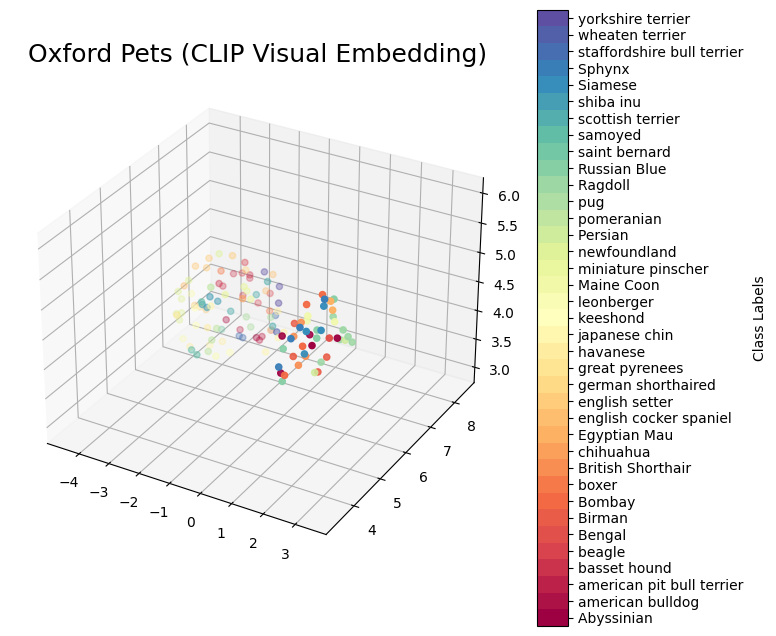

In [ ]:
draw_umap(pets_data, pets_target, pets_classes, n_components=3, title='Oxford Pets (CLIP Visual Embedding)')

## UMAP CLIP Embedding space with Learned Prompts from pretrained model



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## load pre-trained coop
model = CoOp(cifar10_classes, clip_model)
model.load_state_dict(torch.load("/content/drive/My Drive/TrendsCV/weights/CoOp_cifar10.pt"))
model = model.to(device)
model.eval()
print(' ')

Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
 


In [ ]:
hand_crafted_prompts = ['a photo of an airplane, a type of flying vehicle',
                        'a photo of an automobile, a type of ground vehicle',
                        'a photo of a bird, a type of animal that can fly',
                        'a photo of a cat, a type of animal with fur and whiskers',
                        'a photo of a deer, a type of animal with horns',
                        'a photo of a dog, a type of animal very playful',
                        'a photo of a frog, a type of animal that can swim',
                        'a photo of an horse, a type of animal that can run very fast',
                        'a photo of a ship, a type of sea vehicle',
                        'a photo of a truck, a type of vehicle with many and big wheels']

In [ ]:
CIFAR_BATCH_SIZE = 128

#Build dataloaders
cifar10_train_loader = DataLoader(cifar10_train_data, CIFAR_BATCH_SIZE, shuffle=True, drop_last=True)
cifar10_test_loader = DataLoader(cifar10_test_data, CIFAR_BATCH_SIZE, shuffle=False, drop_last=True)

# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(cifar10_train_loader))

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar10_classes]).to(device)
#text_inputs = torch.cat([clip.tokenize(prompt) for prompt in hand_crafted_prompts]).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_inputs)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

img_custom = img_custom.to(device)
image_features, text_features_learned, probits = model(img_custom)

cifar10_image_features = image_features.cpu().detach().numpy()
cifar10_text_features = text_features.cpu().detach().numpy()
cifar10_text_features_learned = text_features_learned.cpu().detach().numpy()
cifar10_target = label_custom.numpy()

print(cifar10_image_features.shape)
print(cifar10_text_features.shape)
print(cifar10_text_features_learned.shape)
print(cifar10_target.shape)

(128, 512)
(10, 512)
(10, 512)
(128,)


<ipython-input-85-5ba9812f9513>:21: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



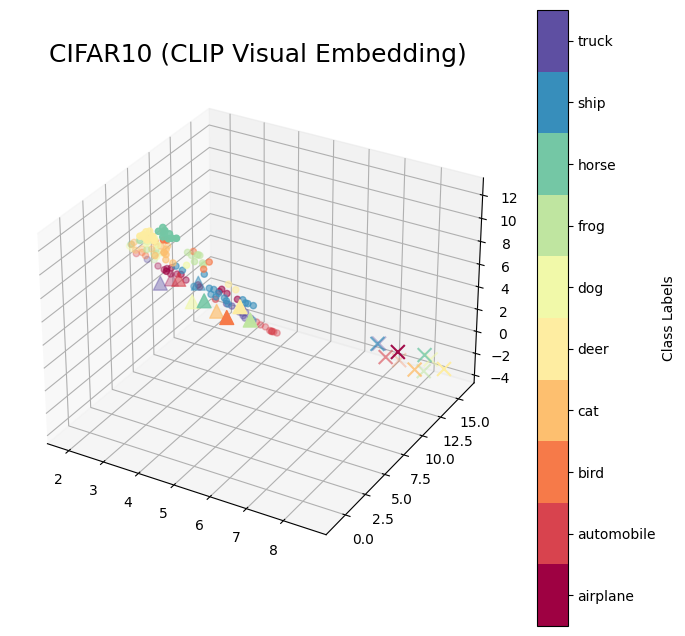

In [ ]:
mapper = umap.UMAP(n_components=3, n_neighbors=9)
image_feat = mapper.fit_transform(cifar10_image_features)
#image_feat = normalize_array(image_feat)
text_feat = mapper.fit_transform(cifar10_text_features)
#text_feat = normalize_array(text_feat)
text_feat_learned = mapper.fit_transform(cifar10_text_features_learned)
#text_feat_learned = normalize_array(text_feat_learned)
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(image_feat[:,0], image_feat[:,1], image_feat[:,2], c=cifar10_target, cmap='Spectral', s=20)
ax.scatter(text_feat[:,0], text_feat[:,1], text_feat[:,2], c=list(cifar10_train_data.class_to_idx.values()), marker='x', cmap='Spectral', s=100)
ax.scatter(text_feat_learned[:,0], text_feat_learned[:,1], text_feat_learned[:,2], c=list(cifar10_train_data.class_to_idx.values()), marker='^', cmap='Spectral', s=100)

# Create a ScalarMappable object to associate with the colorbar
norm = Normalize(vmin=cifar10_target.min(), vmax=cifar10_target.max())
sm = plt.cm.ScalarMappable(cmap='Spectral',norm=norm)
sm.set_array([])

# Add colorbar
cbar = plt.colorbar(sm, boundaries=np.arange(len(cifar10_classes)+1)-0.5, label='Class Labels')
cbar.set_ticks(np.arange(len(cifar10_classes)))
cbar.set_ticklabels(cifar10_classes)
plt.title('CIFAR10 (CLIP Visual Embedding)', fontsize=18)

# Show the plot
plt.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(z=probits.cpu().detach(), colorscale='spectral'))

fig.update_layout(
    title="Cosine Similarity Matrix",
    xaxis_title="Textual Index",
    yaxis_title="Image Index",
    font=dict(size=14),
    width=1000,
    height=1000,
    margin=dict(t=100, r=100, b=100, l=100),
)

fig.show()

### MNIST UMAP

In [ ]:
## load pre-trained coop
model = CoOp(mnist_classes, clip_model)
model.load_state_dict(torch.load("/content/drive/My Drive/TrendsCV/weights/CoOp_MNIST.pt"))
model = model.to(device)
model.eval()
print(' ')

Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
 


In [ ]:
MNIST_BATCH_SIZE = 128

#Build dataloaders
mnist_train_loader = DataLoader(mnist_train_data, MNIST_BATCH_SIZE, shuffle=True, drop_last=True)
mnist_test_loader = DataLoader(mnist_test_data, MNIST_BATCH_SIZE, shuffle=False, drop_last=True)

# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(mnist_train_loader))

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in mnist_classes]).to(device)
#text_inputs = torch.cat([clip.tokenize(prompt) for prompt in hand_crafted_prompts]).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_inputs)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

img_custom = img_custom.to(device)
image_features, text_features_learned, probits = model(img_custom.repeat(1,3,1,1))

mnist_image_features = image_features.cpu().detach().numpy()
mnist_text_features = text_features.cpu().detach().numpy()
mnist_text_features_learned = text_features_learned.cpu().detach().numpy()
mnist_target = label_custom.numpy()

print(mnist_image_features.shape)
print(mnist_text_features.shape)
print(mnist_text_features_learned.shape)
print(mnist_target.shape)

(128, 512)
(10, 512)
(10, 512)
(128,)


<ipython-input-36-9a642fd2e92a>:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, boundaries=np.arange(len(mnist_classes)+1)-0.5, label='Class Labels')


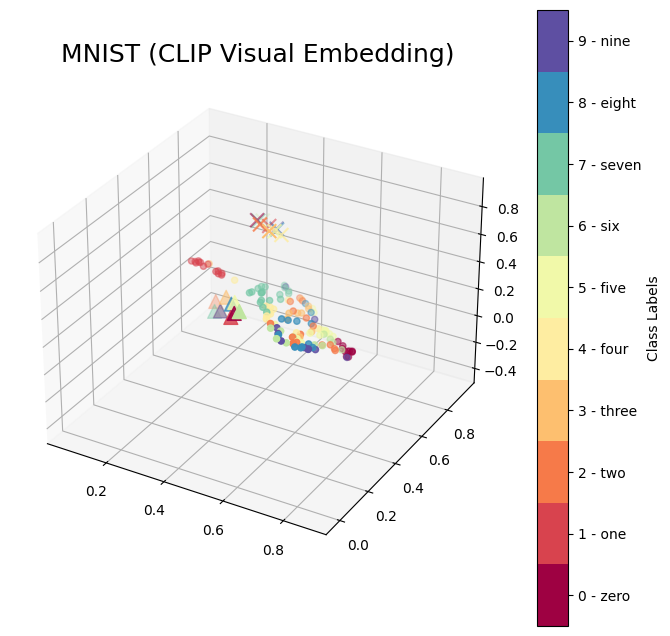

In [ ]:
mapper = umap.UMAP(n_components=3, n_neighbors=9)
image_feat = mapper.fit_transform(mnist_image_features)
image_feat = normalize_array(image_feat)
text_feat = mapper.fit_transform(mnist_text_features)
text_feat = normalize_array(text_feat)
text_feat_learned = mapper.fit_transform(mnist_text_features_learned)
text_feat_learned = normalize_array(text_feat_learned)
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(image_feat[:,0], image_feat[:,1], image_feat[:,2], c=mnist_target, cmap='Spectral', s=20)
ax.scatter(text_feat[:,0], text_feat[:,1], text_feat[:,2], c=list(mnist_train_data.class_to_idx.values()), marker='x', cmap='Spectral', s=100)
ax.scatter(text_feat_learned[:,0], text_feat_learned[:,1], text_feat_learned[:,2], c=list(mnist_train_data.class_to_idx.values()), marker='^', cmap='Spectral', s=100)

# Create a ScalarMappable object to associate with the colorbar
norm = Normalize(vmin=mnist_target.min(), vmax=mnist_target.max())
sm = plt.cm.ScalarMappable(cmap='Spectral',norm=norm)
sm.set_array([])

# Add colorbar
cbar = plt.colorbar(sm, boundaries=np.arange(len(mnist_classes)+1)-0.5, label='Class Labels')
cbar.set_ticks(np.arange(len(mnist_classes)))
cbar.set_ticklabels(mnist_classes)
plt.title('MNIST (CLIP Visual Embedding)', fontsize=18)

# Show the plot
plt.show()

### Oxford pets UMAP

In [ ]:
## load pre-trained coop
model = CoOp(pets_classes, clip_model)
model.load_state_dict(torch.load("/content/drive/My Drive/TrendsCV/weights/CoOp_oxford_pets.pt"))
model = model.to(device)
model.eval()
print(' ')

Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
 


In [ ]:
PETS_BATCH_SIZE = 32

#Build dataloaders
pets_train_loader = DataLoader(pets_train_data, PETS_BATCH_SIZE, shuffle=True, drop_last=True)
pets_test_loader = DataLoader(pets_test_data, PETS_BATCH_SIZE, shuffle=False, drop_last=True)

# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(pets_train_loader))

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in pets_classes]).to(device)
#text_inputs = torch.cat([clip.tokenize(prompt) for prompt in hand_crafted_prompts]).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_inputs)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

img_custom = img_custom.to(device)
image_features, text_features_learned, probits = model(img_custom)

pets_image_features = image_features.cpu().detach().numpy()
pets_text_features = text_features.cpu().detach().numpy()
pets_text_features_learned = text_features_learned.cpu().detach().numpy()
pets_target = label_custom.numpy()

print(pets_image_features.shape)
print(pets_text_features.shape)
print(pets_text_features_learned.shape)
print(pets_target.shape)

(32, 512)
(37, 512)
(37, 512)
(32,)


<ipython-input-32-0bdb4333b27d>:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, boundaries=np.arange(len(pets_classes)+1)-0.5, label='Class Labels')


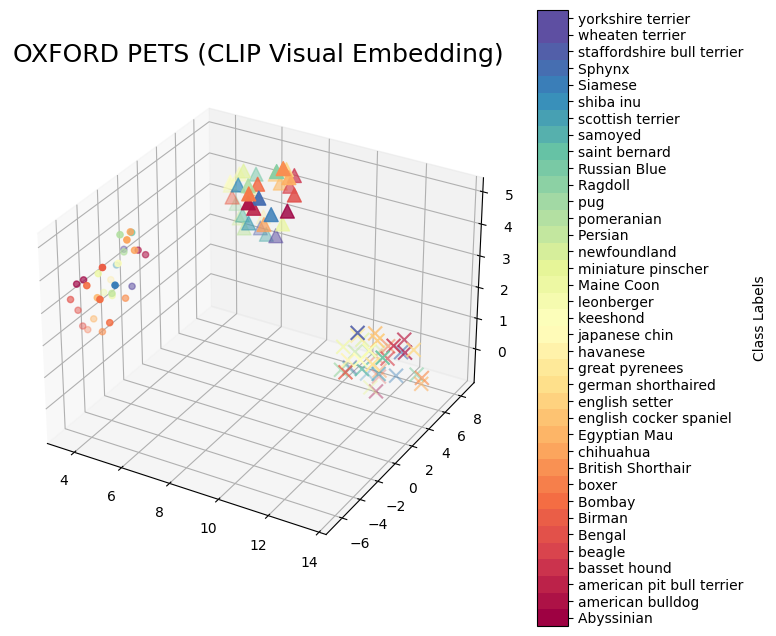

In [ ]:
mapper = umap.UMAP(n_components=3, n_neighbors=9)
image_feat = mapper.fit_transform(pets_image_features)
#image_feat = normalize_array(image_feat)
text_feat = mapper.fit_transform(pets_text_features)
#text_feat = normalize_array(text_feat)
text_feat_learned = mapper.fit_transform(pets_text_features_learned)
#text_feat_learned = normalize_array(text_feat_learned)
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(image_feat[:,0], image_feat[:,1], image_feat[:,2], c=pets_target, cmap='Spectral', s=20)
ax.scatter(text_feat[:,0], text_feat[:,1], text_feat[:,2], c=range(len(pets_classes)), marker='x', cmap='Spectral', s=100)
ax.scatter(text_feat_learned[:,0], text_feat_learned[:,1], text_feat_learned[:,2], c=range(len(pets_classes)), marker='^', cmap='Spectral', s=100)

# Create a ScalarMappable object to associate with the colorbar
norm = Normalize(vmin=pets_target.min(), vmax=pets_target.max())
sm = plt.cm.ScalarMappable(cmap='Spectral',norm=norm)
sm.set_array([])

# Add colorbar
cbar = plt.colorbar(sm, boundaries=np.arange(len(pets_classes)+1)-0.5, label='Class Labels')
cbar.set_ticks(np.arange(len(pets_classes)))
cbar.set_ticklabels(pets_classes)
plt.title('OXFORD PETS (CLIP Visual Embedding)', fontsize=18)

# Show the plot
plt.show()

## Define the CoCoOp Model

In [ ]:
from collections import OrderedDict

class PromptLearnerMetaNet(nn.Module):
    def __init__(self, clip_model, classnames, n_context=16, init_words='', class_token_pos = "end"):
        super().__init__()
        n_cls = len(classnames)
        n_ctx = n_context
        ctx_init = init_words
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]
        vis_dim = clip_model.visual.output_dim

        if ctx_init:
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(" "))
            prompt = clip.tokenize(ctx_init)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            # random initialization
            ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        self.ctx = nn.Parameter(ctx_vectors)

        self.meta_net = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(vis_dim, vis_dim // 16)),
            ('relu', nn.ReLU(inplace=True)),
            ('linear2', nn.Linear(vis_dim // 16, ctx_dim))
        ]))

        self.meta_net.half()

        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [prompt_prefix + ' ' + name + '.' for name in classnames]

        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts])
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)

        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # CLS, EOS

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens

    def construct_prompts(self, ctx, prefix, suffix, label=None):
        if label is not None:
            prefix = prefix[label]
            suffix = suffix[label]

        prompts = torch.cat([prefix, ctx, suffix], dim=1)
        return prompts

    def forward(self, im_features):
        prefix = self.token_prefix
        suffix = self.token_suffix

        ctx = self.ctx

        bias = self.meta_net(im_features)
        bias = bias.unsqueeze(1)
        ctx = ctx.unsqueeze(0)
        ctx_shifted = ctx + bias

        prompts = []
        for shift in ctx_shifted:
            ctx_i = shift.unsqueeze(0).expand(self.n_cls, -1, -1)
            pts_i = self.construct_prompts(ctx_i, prefix, suffix)  # (n_cls, n_tkn, ctx_dim)
            prompts.append(pts_i)
        prompts = torch.stack(prompts)

        return prompts

In [ ]:
class CoCoOp(nn.Module):
    def __init__(self, classnames, clip_model):
        super().__init__()
        self.prompt_learner = PromptLearnerMetaNet(clip_model, classnames)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image, label=None):
        tokenized_prompts = self.tokenized_prompts
        logit_scale = self.logit_scale.exp()

        image_features = self.image_encoder(image.type(self.dtype))
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        prompts = self.prompt_learner(image_features)

        logits = []

        for pts, imf in zip(prompts, image_features):
            text_features = self.text_encoder(pts, tokenized_prompts)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            logit = logit_scale * imf @ text_features.t()
            logits.append(logit)
        logits = torch.stack(logits)

        return logits

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

datasets = ['oxford_pets', 'cifar10', 'cifar100', 'food101']

clip_model = clip_model.to('cpu')

## Iterate through all datasets
for dataset in datasets:
    print(f'training CoOp on {dataset}...')

    # instantiate the model
    if dataset == 'oxford_pets':
        model = CoCoOp(pets_classes, clip_model)
    elif dataset == 'food101':
        model = CoCoOp(food_classes, clip_model)
    elif dataset == 'cifar100':
        model = CoCoOp(cifar_classes, clip_model)
    elif dataset == 'cifar10':
        model = CoCoOp(cifar10_classes, clip_model)

    ## Turning off gradients in both the image and the text encoder
    for name, param in model.named_parameters():
                if "prompt_learner" not in name:
                    param.requires_grad_(False)

    model = model.to(device)

    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()

    # NOTE: only give prompt_learner to the optimizer
    optimizer = torch.optim.SGD(params=model.prompt_learner.parameters(), lr=0.002)

    # Train model
    if dataset == 'oxford_pets':
        pets_model_results = train(model=model, train_loader=pets_train_loader, test_loader=pets_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
    elif dataset == 'food101':
        food_model_results = train(model=model, train_loader=food_train_loader, test_loader=food_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
    elif dataset == 'cifar100':
        cifar_model_results = train(model=model, train_loader=cifar_train_loader, test_loader=cifar_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
    elif dataset == 'cifar10':
        cifar10_model_results = train(model=model, train_loader=cifar10_train_loader, test_loader=cifar10_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)

    ## Save the model
    model_name = f'CoCoOp_{dataset}.pt'
    save_model(model=model, target_dir='models', model_name=model_name)

    ## Plot curves
    #plot_loss_curves(model_results)

training CoOp on oxford_pets...
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16


  0%|          | 0/5 [00:00<?, ?it/s]

OutOfMemoryError: ignored

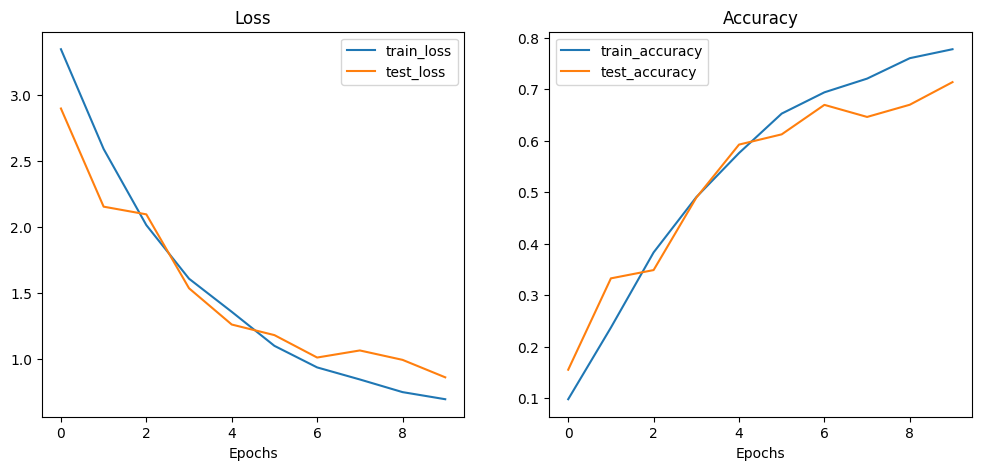

In [ ]:
# Plot the results
plot_loss_curves(model_results)

## MaPLe : Multi-Modal Prompt Learning


In [ ]:
class MapleTextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts, deeper_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)

        x = x.permute(1,0,2)

        combined = [x, deeper_prompts, 0]
        combined_tensor = torch.tensor(combined)
        outputs = self.transformer(combined_tensor)
        x = outputs[0]

        x = x.permute(1,0,2)

        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x

In [ ]:
import copy
def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class MultiModalPromptLearner(nn.Module):
    def __init__(self, classnames, clip_model, n_context=2, context_init='a photo of a', depth=9):
        super().__init__()
        n_cls = len(classnames)
        n_ctx = n_context
        ctx_init = context_init
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]
        self.prompts_depth = depth
        assert (depth >= 1 and depth <= 12), "for MaPLe depth should be max 12"

        if ctx_init:
            # use given words to initialize context vectors
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(' '))
            prompt = clip.tokenize(ctx_init)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            ctx_vectors = embedding[0, 1: 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            # random initialization
            ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        print('MaPLe design: Multi-modal Prompt Learning')
        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of MaPLe context words (tokens): {n_ctx}")

        self.proj = nn.Linear(ctx_dim, 768)
        self.proj.half()
        self.ctx = nn.Parameter(ctx_vectors)

        self.compound_prompts_text = nn.ParameterList([nn.Parameter(torch.empty(n_ctx, 512)) for _ in range(self.prompts_depth - 1)])
        for single_para in self.compound_prompts_text:
            nn.init.normal_(single_para, std=0.02)

        single_layer = nn.Linear(ctx_dim, 768)
        self.compound_prompt_projections = _get_clones(single_layer, self.prompts_depth - 1)

        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [prompt_prefix + " " + name + "." for name in classnames]

        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts])  # (n_cls, n_tkn)
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)

        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx:, :])  # CLS, EOS

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens

    def construct_prompts(self, ctx, prefix, suffix, label=None):
        if label is not None:
            prefix = prefix[label]
            suffix = suffix[label]

        prompts = torch.cat([prefix, ctx, suffix],dim=1)

        return prompts

    def forward(self):
        ctx = self.ctx

        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        prefix = self.token_prefix
        suffix = self.token_suffix
        prompts = self.construct_prompts(ctx, prefix, suffix)

        # Before returning, need to transform
        # prompts to 768 for the visual side
        visual_deep_prompts = []
        for index, layer in enumerate(self.compound_prompt_projections):
            visual_deep_prompts.append(layer(self.compound_prompts_text[index]))
        # Now the other way around
        # We will project the textual prompts from 512 to 768
        return prompts, self.proj(self.ctx), self.compound_prompts_text, visual_deep_prompts

In [ ]:
class MaPLe(nn.Module):
    def __init__(self, classnames, clip_model):
        super().__init__()
        self.prompt_learner = MultiModalPromptLearner(classnames, clip_model)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = MapleTextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image, label=None):
        tokenized_prompts = self.tokenized_prompts
        logit_scale = self.logit_scale.exp()

        prompts, shared_ctx, deep_compound_prompts_text, deep_compound_prompts_vision = self.prompt_learner()
        text_features = self.text_encoder(prompts, tokenized_prompts, deep_compound_prompts_text)
        image_features = self.image_encoder(image.type(self.dtype), shared_ctx, deep_compound_prompts_vision)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logits = logit_scale * image_features @ text_features.t()

        return logits

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 3

datasets = ['oxford_pets', 'cifar10', 'cifar100', 'food101']

clip_model = clip_model.to('cpu')

## Iterate through all datasets
for dataset in datasets:
    print(f'training CoOp on {dataset}...')

    # instantiate the model
    if dataset == 'oxford_pets':
        model = MaPLe(pets_classes, clip_model)
    elif dataset == 'food101':
        model = MaPLe(food_classes, clip_model)
    elif dataset == 'cifar100':
        model = MaPLe(cifar_classes, clip_model)
    elif dataset == 'cifar10':
        model = MaPLe(cifar10_classes, clip_model)

    ## Turning off gradients in both the image and the text encoder
    for name, param in model.named_parameters():
                if "prompt_learner" not in name:
                    param.requires_grad_(False)

    model = model.to(device)

    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()

    # NOTE: only give prompt_learner to the optimizer
    optimizer = torch.optim.SGD(params=model.prompt_learner.parameters(), lr=0.002)

    # Train model
    if dataset == 'oxford_pets':
        pets_model_results = train(model=model, train_loader=pets_train_loader, test_loader=pets_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
    elif dataset == 'food101':
        food_model_results = train(model=model, train_loader=food_train_loader, test_loader=food_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
    elif dataset == 'cifar100':
        cifar_model_results = train(model=model, train_loader=cifar_train_loader, test_loader=cifar_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
    elif dataset == 'cifar10':
        cifar10_model_results = train(model=model, train_loader=cifar10_train_loader, test_loader=cifar10_test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)

    ## Save the model
    model_name = f'CoCoOp_{dataset}.pt'
    save_model(model=model, target_dir='models', model_name=model_name)


training CoOp on oxford_pets...
MaPLe design: Multi-modal Prompt Learning
Initial context: "a photo of a"
Number of MaPLe context words (tokens): 4


  0%|          | 0/3 [00:00<?, ?it/s]

OutOfMemoryError: ignored

## KgCoOp - Knowledge-guided Context Optimization


In [33]:
class KgCoOp(nn.Module):
    def __init__(self, classnames, clip_model):
        super().__init__()
        self.prompt_learner = PromptLearner(clip_model, classnames, n_context=16, init_words='', class_token_pos = "end", csc=False).to(device)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts.to(device)
        self.image_encoder = clip_model.visual.to(device)
        self.text_encoder = TextEncoder(clip_model).to(device)
        self.logit_scale = clip_model.logit_scale.to(device)
        self.dtype = clip_model.dtype

    def forward(self, image, label):
        image_features = self.image_encoder(image.type(self.dtype))

        prompts = self.prompt_learner()
        tokenized_prompts = self.tokenized_prompts
        text_features = self.text_encoder(prompts, tokenized_prompts)
        generic_text = []
        for l in label:
          generic_text.append("a photo of a {}".format(list(class_names)[l]))
        text_embeds = clip.tokenize(texts=generic_text).to(device)
        text_embeds = clip_model.encode_text(text_embeds)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits, (text_features, text_embeds)

In [35]:
class KgCoOpLoss(nn.Module):
    def __init__(self, weight=1.0):
        super(KgCoOpLoss, self).__init__()
        self.weight = weight

    def forward(self, input_tensor, target):
        # Define your custom loss computation here
        custom_loss = torch.mean((input_tensor - target) ** 2)

        return custom_loss * self.weight

In [31]:
class ProGradLoss(nn.Module):
    def __init__(self, T):
        super(ProGradLoss, self).__init__()
        self.T = T

    def forward(self, stu_logits, tea_logits):
        tea_prob = torch.softmax(tea_logits / self.T, dim=-1)
        kl_loss = -tea_prob * torch.log_softmax(stu_logits / self.T, -1) * self.T * self.T
        kl_loss = kl_loss.sum(1).mean()

        return kl_loss

In [29]:
def custom_train_step(model, data_loader, optimizer, loss_fn, classes, device=device, other_loss=None):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (images, classes) in enumerate(data_loader):
        if images.shape[1] > 3:
            continue
        images, classes_to_check = images.to(device), classes.to(device)

        if other_loss and isinstance(other_loss, KgCoOpLoss):
          pred = model(images, custom_train_step)
          pred, (l_emb, c_emb) = pred
          train_loss = other_loss(l_emb, c_emb).item()
        else:
          _ ,_, pred = model(images)

        loss = loss_fn(pred,classes_to_check)
        train_loss += loss.item()
        optimizer.zero_grad()


        if other_loss and isinstance(other_loss, ProGradLoss):
          new_gradient = {}
          loss.backward()
          domain_gradient = {name: param.grad for name, param in model.named_parameters()}
          optimizer.zero_grad()
          ground_truth = CLIP_ZeroShot(classes, clip_model)
          general_loss = other_loss(ground_truth(images)[0], pred)
          general_loss.backward()
          general_gradient = {name: param.grad for name, param in model.named_parameters()}
          for dg, gg in zip(domain_gradient.items(), general_gradient.items()):
            name, dg = dg
            name, gg = gg
            angle = torch.dot(dg, gg).item()
            if angle >= 0:
              new_gradient[name] = dg
            else:
              other = (torch.dot(dg,gg) / (torch.norm(gg)*torch.norm(gg))) * gg
              new_value = torch.sub(dg, other, alpha=0.5)
              new_gradient[name] = new_value

        for name,param in model.named_parameters():
          param.grad = new_gradient[name]

        else:
          loss.backward()


        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(pred, dim=1), dim=1)
        train_acc += (y_pred_class == classes_to_check).sum().item() / len(pred)

    train_loss = train_loss / len(data_loader)
    train_acc = train_acc / len(data_loader)
    return train_loss, train_acc

def custom_test_step(model, data_loader, loss_fn, classes, device=device, other_loss=None):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (images, classes) in enumerate(data_loader):
            if images.shape[1] > 3:
                continue
            images, classes = images.to(device), classes.to(device)
            if other_loss and isinstance(other_loss, KgCoOpLoss):
              pred = model(images, classes)
              pred, (l_emb, c_emb) = pred
              ground_truth = CLIP_ZeroShot(classes, clip_model)
              test_loss = other_loss(l_emb, c_emb).item() + other_loss(ground_truth(images)[0], pred)
            else:
              pred = model(images)

            loss = loss_fn(pred, classes)
            test_loss += loss.item()

            pred_labels = pred.argmax(dim=1)
            test_acc += ((pred_labels == classes).sum().item() / len(pred_labels))

        test_loss = test_loss / len(data_loader)
        test_acc = test_acc / len(data_loader)
    return test_loss, test_acc

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# instantiate the model
model = KgCoOp(pets_classes, clip_model)

## Turning off gradients in both the image and the text encoder
for name, param in model.named_parameters():
            if "prompt_learner" not in name:
                param.requires_grad_(False)

model = model.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

# NOTE: only give prompt_learner to the optimizer
optimizer = torch.optim.SGD(params=model.prompt_learner.parameters(), lr=0.002)

# Train model
model_results = train(model=model, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS, other_loss=CustomLoss(weight=0.1))

Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0002 | train_acc: 0.4755 | test_loss: 0.0001 | test_acc: 0.7539
Epoch: 2 | train_loss: 0.0005 | train_acc: 0.7734 | test_loss: 0.0000 | test_acc: 0.8035
Epoch: 3 | train_loss: 0.0001 | train_acc: 0.8117 | test_loss: 0.0004 | test_acc: 0.8166
Epoch: 4 | train_loss: 0.0000 | train_acc: 0.8383 | test_loss: 0.0000 | test_acc: 0.8149
Epoch: 5 | train_loss: 0.0001 | train_acc: 0.8470 | test_loss: 0.0003 | test_acc: 0.8141
Epoch: 6 | train_loss: 0.0000 | train_acc: 0.8606 | test_loss: 0.0000 | test_acc: 0.8138
Epoch: 7 | train_loss: 0.0003 | train_acc: 0.8685 | test_loss: 0.0000 | test_acc: 0.8327
Epoch: 8 | train_loss: 0.0002 | train_acc: 0.8745 | test_loss: 0.0000 | test_acc: 0.8324
Epoch: 9 | train_loss: 0.0000 | train_acc: 0.8753 | test_loss: 0.0000 | test_acc: 0.8327
Epoch: 10 | train_loss: 0.0000 | train_acc: 0.8902 | test_loss: 0.0000 | test_acc: 0.8256


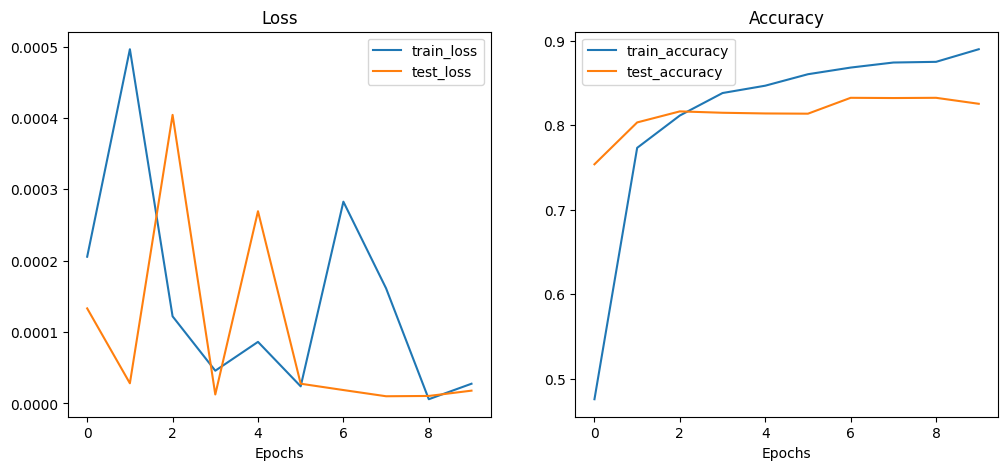

In [ ]:
plot_loss_curves(model_results)

In [ ]:
lambdas = [0.1, 0.3, 0.5, 0.7, 1.0]
NUM_EPOCHS = 5

for l in lambdas:
    # instantiate the model
    model = KgCoOp(pets_classes, clip_model)

    ## Turning off gradients in both the image and the text encoder
    for name, param in model.named_parameters():
                if "prompt_learner" not in name:
                    param.requires_grad_(False)

    model = model.to(device)

    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()

    # NOTE: only give prompt_learner to the optimizer
    optimizer = torch.optim.SGD(params=model.prompt_learner.parameters(), lr=0.002)

    # Train model
    print('Testing with...')
    print(f'lambda: {l}')
    model_results = train(model=model, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS, other_loss=KgCoOpLoss(l))

    # Plot the results
    plot_loss_curves(model_results)

Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
Testing with...
lambda: 0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0002 | train_acc: 0.4082 | test_loss: 0.0002 | test_acc: 0.6544
Epoch: 2 | train_loss: 0.0002 | train_acc: 0.7082 | test_loss: 0.0000 | test_acc: 0.7422
Epoch: 3 | train_loss: 0.0000 | train_acc: 0.7796 | test_loss: 0.0000 | test_acc: 0.7833
Epoch: 4 | train_loss: 0.0002 | train_acc: 0.8065 | test_loss: 0.0004 | test_acc: 0.7934
Epoch: 5 | train_loss: 0.0002 | train_acc: 0.8160 | test_loss: 0.0007 | test_acc: 0.7893
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
Testing with...
lambda: 0.3


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0004 | train_acc: 0.4030 | test_loss: 0.0003 | test_acc: 0.7334
Epoch: 2 | train_loss: 0.0000 | train_acc: 0.7644 | test_loss: 0.0000 | test_acc: 0.7803
Epoch: 3 | train_loss: 0.0000 | train_acc: 0.8114 | test_loss: 0.0002 | test_acc: 0.8147
Epoch: 4 | train_loss: 0.0000 | train_acc: 0.8288 | test_loss: 0.0000 | test_acc: 0.8174
Epoch: 5 | train_loss: 0.0000 | train_acc: 0.8492 | test_loss: 0.0000 | test_acc: 0.8297
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
Testing with...
lambda: 0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0003 | train_acc: 0.2519 | test_loss: 0.0009 | test_acc: 0.5740
Epoch: 2 | train_loss: 0.0005 | train_acc: 0.6894 | test_loss: 0.0002 | test_acc: 0.7277
Epoch: 3 | train_loss: 0.0003 | train_acc: 0.7793 | test_loss: 0.0001 | test_acc: 0.7476
Epoch: 4 | train_loss: 0.0001 | train_acc: 0.8141 | test_loss: 0.0000 | test_acc: 0.7871
Epoch: 5 | train_loss: 0.0000 | train_acc: 0.8310 | test_loss: 0.0000 | test_acc: 0.8013
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
Testing with...
lambda: 0.7


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0008 | train_acc: 0.2435 | test_loss: 0.0008 | test_acc: 0.5001
Epoch: 2 | train_loss: 0.0001 | train_acc: 0.6707 | test_loss: 0.0004 | test_acc: 0.7141
Epoch: 3 | train_loss: 0.0000 | train_acc: 0.7736 | test_loss: 0.0002 | test_acc: 0.7760
Epoch: 4 | train_loss: 0.0008 | train_acc: 0.8030 | test_loss: 0.0001 | test_acc: 0.8013
Epoch: 5 | train_loss: 0.0001 | train_acc: 0.8274 | test_loss: 0.0001 | test_acc: 0.8043
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
Testing with...
lambda: 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

## ProGrad

In [36]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# instantiate the model (Coop) with custom training
model = CoOp(pets_classes, clip_model)

## Turning off gradients in both the image and the text encoder
for name, param in model.named_parameters():
            if "prompt_learner" not in name:
                param.requires_grad_(False)

model = model.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

# NOTE: only give prompt_learner to the optimizer
optimizer = torch.optim.SGD(params=model.prompt_learner.parameters(), lr=0.002)

# Train model
model_result = custom_train(model=model, train_loader=pets_train_loader, test_loader=pets_test_loader, optimizer=optimizer, loss_fn=loss_fn, classes=pets_classes, epochs=NUM_EPOCHS, other_loss=ProGradLoss(0.5))

Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16


  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: ignored

## Plot the results

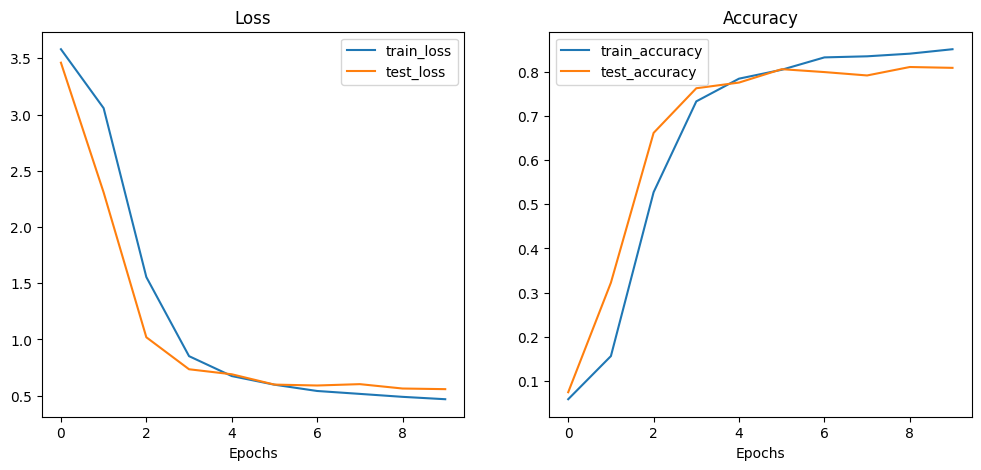

In [ ]:
plot_loss_curves(model_results)